In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Final Fashion Dataset.csv')

In [ ]:
data.head()

,user_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,ratings,review,Month,Price (USD)
0,93810,8493,Women,Apparel,Bottomwear,Skirts,Black,Fall,2011.0,Casual,Forever New Women Black Skirts,8493.jpg,http://assets.myntassets.com/v1/images/style/p...,5,Amazing quality! Definitely recommend. Would r...,November,46
1,24592,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,Fabindia Men Grey Mangalgiri Kurta,30757.jpg,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy..",September,29
2,13278,14881,Women,Accessories,Bags,Handbags,Black,Summer,2011.0,Casual,United Colors of Benetton Women Solid Black Ha...,14881.jpg,http://assets.myntassets.com/v1/images/style/p...,3,"It's okay, nothing special.!",October,39
3,46048,48449,Men,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,French Connection Men Blue T-shirt,48449.jpg,http://assets.myntassets.com/v1/images/style/p...,5,"Comfortable and stylish, worth the price. and ...",August,39
4,42098,4697,Unisex,Accessories,Watches,Watches,Black,Winter,2016.0,Sports,ADIDAS Unisex Digital Duramo Black Watch,4697.jpg,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy.!",March,33


In [ ]:
# Encode categorical features (e.g., gender, color, usage)
label_encoder_gender = LabelEncoder()
data['gender_encoded'] = label_encoder_gender.fit_transform(data['gender'])

label_encoder_color = LabelEncoder()
data['baseColour_encoded'] = label_encoder_color.fit_transform(data['baseColour'])

label_encoder_usage = LabelEncoder()
data['usage_encoded'] = label_encoder_usage.fit_transform(data['usage'])

In [ ]:
# Scale numerical features (e.g., price)
scaler = StandardScaler()
data['Price (USD)_scaled'] = scaler.fit_transform(data[['Price (USD)']])

In [ ]:
# Encode subcategory as target variable (One-Hot Encoding for classification)
label_encoder_subcategory = LabelEncoder()
data['subCategory_encoded'] = label_encoder_subcategory.fit_transform(data['subCategory'])

In [ ]:
data.head()

,user_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,...,link,ratings,review,Month,Price (USD),gender_encoded,baseColour_encoded,usage_encoded,Price (USD)_scaled,subCategory_encoded
0,93810,8493,Women,Apparel,Bottomwear,Skirts,Black,Fall,2011.0,Casual,...,http://assets.myntassets.com/v1/images/style/p...,5,Amazing quality! Definitely recommend. Would r...,November,46,4,1,0,1.075171,2
1,24592,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,...,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy..",September,29,2,13,1,-0.426540,10
2,13278,14881,Women,Accessories,Bags,Handbags,Black,Summer,2011.0,Casual,...,http://assets.myntassets.com/v1/images/style/p...,3,"It's okay, nothing special.!",October,39,4,1,0,0.456819,0
3,46048,48449,Men,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,...,http://assets.myntassets.com/v1/images/style/p...,5,"Comfortable and stylish, worth the price. and ...",August,39,2,2,0,0.456819,10
4,42098,4697,Unisex,Accessories,Watches,Watches,Black,Winter,2016.0,Sports,...,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy.!",March,33,3,1,5,-0.073196,12


In [ ]:
# Split the dataset into input features (X) and target labels (y)
X = data[['gender_encoded', 'baseColour_encoded', 'usage_encoded', 'Price (USD)_scaled']]
y = pd.get_dummies(data['subCategory'])  # One-hot encoded target

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define model
def create_model(num_gender, num_color, num_usage):
    # Input layers for each feature
    input_gender = Input(shape=(1,), name='gender')
    input_color = Input(shape=(1,), name='baseColour')
    input_usage = Input(shape=(1,), name='usage')
    input_price = Input(shape=(1,), name='Price (USD)')

    # Embedding layers for categorical features
    gender_embedding = Embedding(input_dim=len(data['gender_encoded'].unique()), output_dim=4)(input_gender)
    color_embedding = Embedding(input_dim=len(data['baseColour_encoded'].unique()), output_dim=44)(input_color)
    usage_embedding = Embedding(input_dim=len(data['usage_encoded'].unique()), output_dim=7)(input_usage)

    #Flatten the embeddings
       # Flatten the embeddings
    gender_flat = Flatten()(gender_embedding)
    color_flat = Flatten()(color_embedding)
    usage_flat = Flatten()(usage_embedding)


    # Concatenate all features
    concat = Concatenate()([gender_flat, color_flat, usage_flat, input_price])

    # Hidden layers
    dense_layer = Dense(128, activation='relu')(concat)
    dense_layer = Dense(64, activation='relu')(dense_layer)

    # Output layers for each subcategory
    output_shoes = Dense(1, activation='sigmoid', name='shoes')(dense_layer)
    output_bags = Dense(1, activation='sigmoid', name='bags')(dense_layer)
    output_watches = Dense(1, activation='sigmoid', name='watches')(dense_layer)
    output_flip_flops = Dense(1, activation='sigmoid', name='flip_flops')(dense_layer)
    output_jewellery = Dense(1, activation='sigmoid', name='jewellery')(dense_layer)
    output_eyewear = Dense(1, activation='sigmoid', name='eyewear')(dense_layer)
    output_belts = Dense(1, activation='sigmoid', name='belts')(dense_layer)
    output_saree = Dense(1, activation='sigmoid', name='saree')(dense_layer)
    output_loungewear = Dense(1, activation='sigmoid', name='loungewear')(dense_layer)
    output_wallets = Dense(1, activation='sigmoid', name='wallets')(dense_layer)
    output_socks = Dense(1, activation='sigmoid', name='socks')(dense_layer)

    # Model
    model = Model(inputs=[input_gender, input_color, input_usage, input_price],
                  outputs=[output_shoes, output_bags, output_watches, output_flip_flops, output_jewellery,
                           output_eyewear, output_belts, output_saree, output_loungewear, output_wallets,
                           output_socks])
    return model


In [ ]:
# Step 3: Create and Compile the Model
num_gender = len(data['gender_encoded'].unique())
num_color = len(data['baseColour_encoded'].unique())
num_usage = len(data['usage_encoded'].unique())

In [ ]:
model = create_model(num_gender, num_color, num_usage)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'] * len(model.output_names))

In [ ]:
# Step 4: Train the Model
model.fit(
    [X_train['gender_encoded'], X_train['baseColour_encoded'], X_train['usage_encoded'], X_train['Price (USD)_scaled']],  # Passing each feature separately
    [y_train['Shoes'], y_train['Bags'], y_train['Watches'], y_train['Flip Flops'], y_train['Jewellery'],
     y_train['Eyewear'], y_train['Belts'], y_train['Saree'], y_train['Loungewear and Nightwear'], y_train['Wallets'],
     y_train['Socks']],  # Passing each target separately
    epochs=10,
    batch_size=32,
    validation_data=(
        [X_val['gender_encoded'], X_val['baseColour_encoded'], X_val['usage_encoded'], X_val['Price (USD)_scaled']],  # Validation features
        [y_val['Shoes'], y_val['Bags'], y_val['Watches'], y_val['Flip Flops'], y_val['Jewellery'],
         y_val['Eyewear'], y_val['Belts'], y_val['Saree'], y_val['Loungewear and Nightwear'], y_val['Wallets'],
         y_val['Socks']]  # Validation targets
    )
)

Epoch 1/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - bags_accuracy: 0.8716 - belts_accuracy: 0.9769 - eyewear_accuracy: 0.9617 - flip_flops_accuracy: 0.9601 - jewellery_accuracy: 0.9594 - loss: 2.5956 - loungewear_accuracy: 0.9315 - saree_accuracy: 0.9697 - shoes_accuracy: 0.7908 - socks_accuracy: 0.9598 - wallets_accuracy: 0.9714 - watches_accuracy: 0.8865 - val_bags_accuracy: 0.9170 - val_belts_accuracy: 0.9796 - val_eyewear_accuracy: 0.9719 - val_flip_flops_accuracy: 0.9746 - val_jewellery_accuracy: 0.9716 - val_loss: 1.4677 - val_loungewear_accuracy: 0.9888 - val_saree_accuracy: 0.9910 - val_shoes_accuracy: 0.8198 - val_socks_accuracy: 0.9829 - val_wallets_accuracy: 0.9774 - val_watches_accuracy: 0.9365
Epoch 2/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - bags_accuracy: 0.9187 - belts_accuracy: 0.9749 - eyewear_accuracy: 0.9700 - flip_flops_accuracy: 0.9750 - jewellery_accuracy: 0.9761 - loss: 1.4873 - loungewear_accuracy: 0.9864 - saree_accuracy: 0.9881 - shoes_accuracy: 0.824

In [ ]:
# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gender (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ baseColour (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ usage (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 4)           │             20 │ gender[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 44)          │          1,980 │ baseColour[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 7)           │             49 │ usage[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 4)              │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 44)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 7)              │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Price (USD) (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56)             │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0],       │
│                           │                        │                │ flatten_2[0][0], Price │
│                           │                        │                │ (USD)[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          7,296 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shoes (Dense)             │ (None, 1)              │             65 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bags (Dense)              │ (None, 1)              │             65 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ watches (Dense)           │ (None, 1)              │             65 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flip_flops (Dense)        │ (None, 1)              │             65 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ jewellery (Dense)         │ (None, 1)              │             65 │ dense_1[0][0]          │
├──────────────────────

 Total params: 54,950 (214.65 KB)

 Trainable params: 18,316 (71.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,634 (143.11 KB)

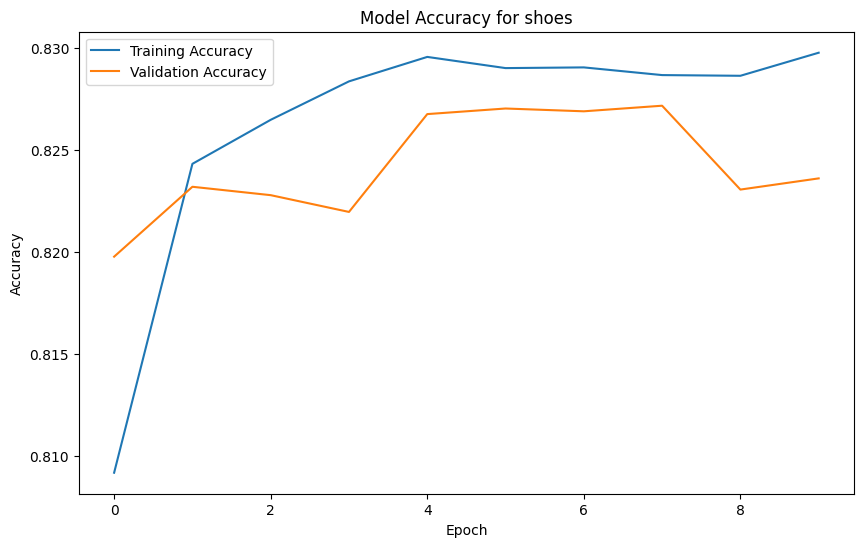

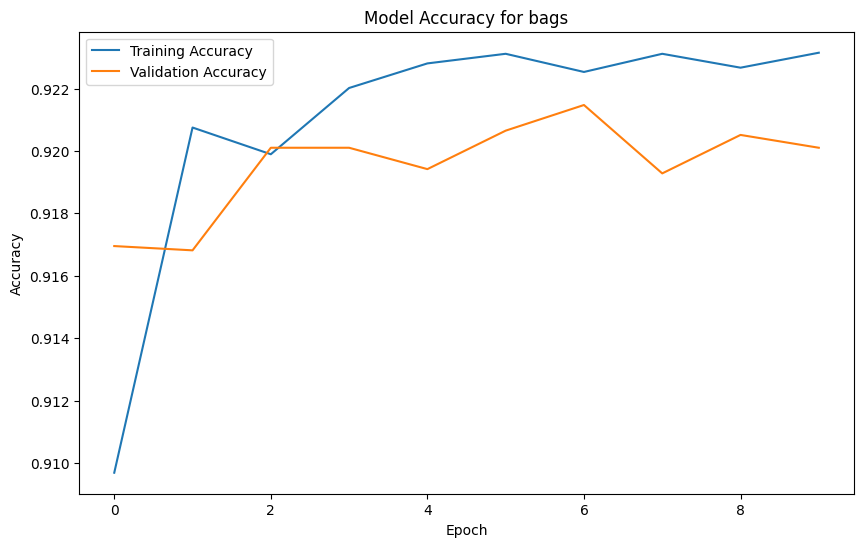

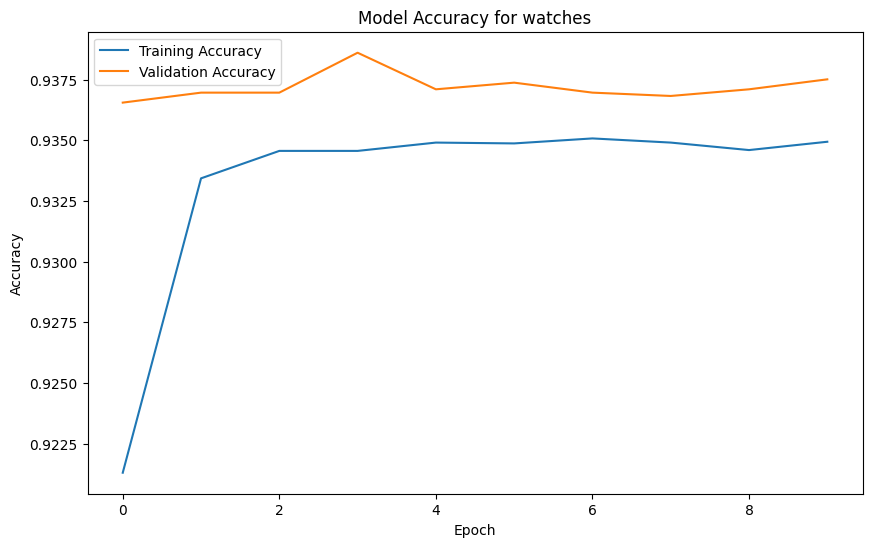

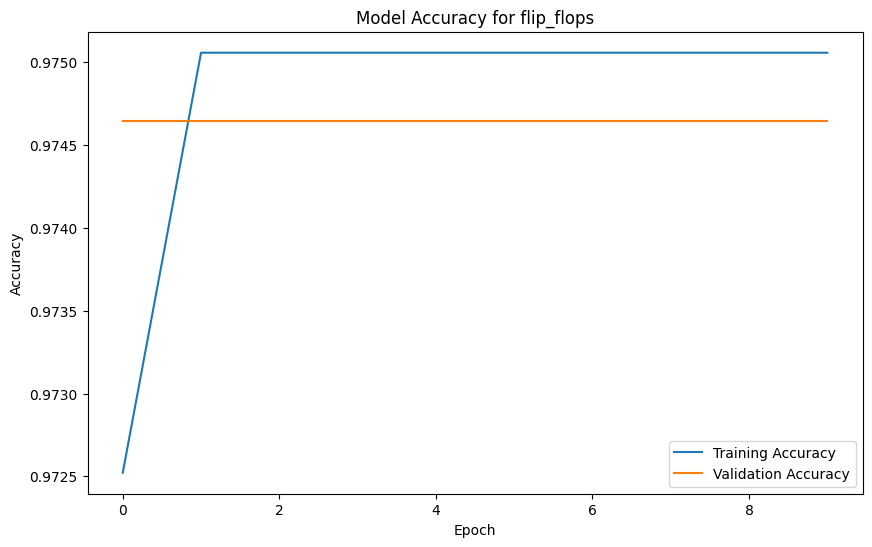

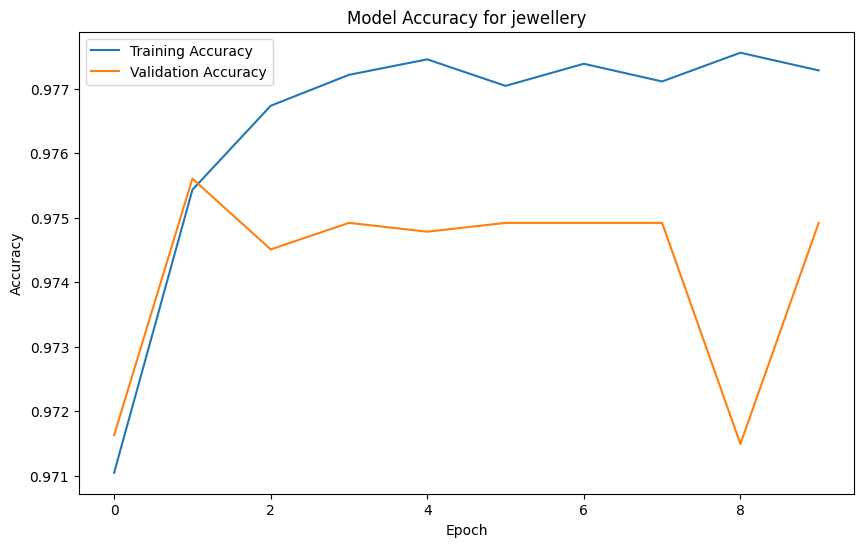

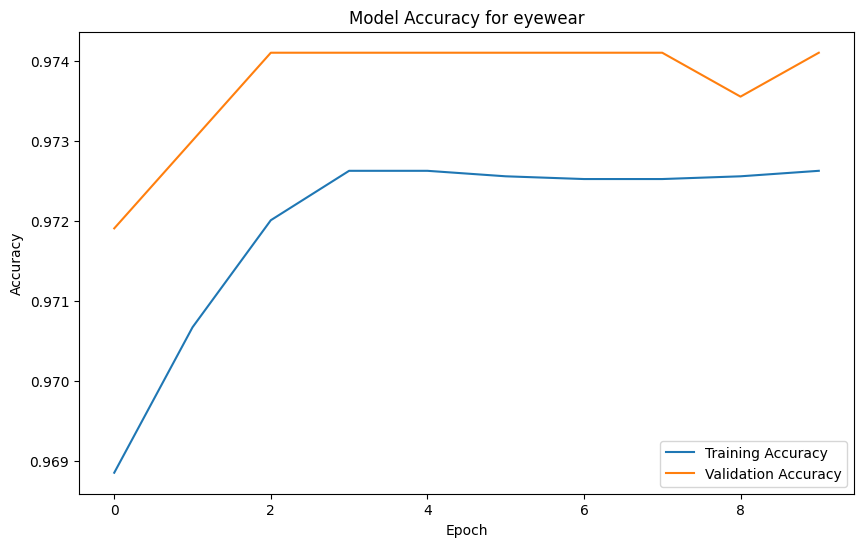

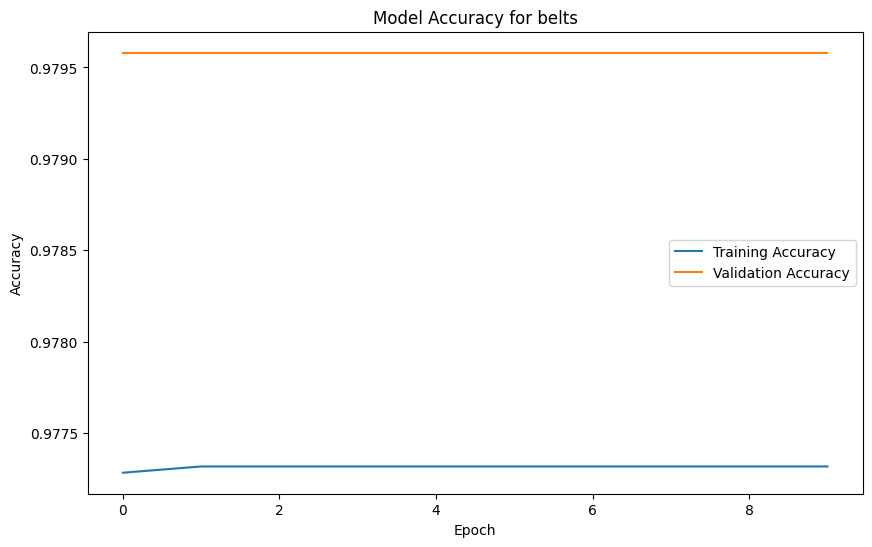

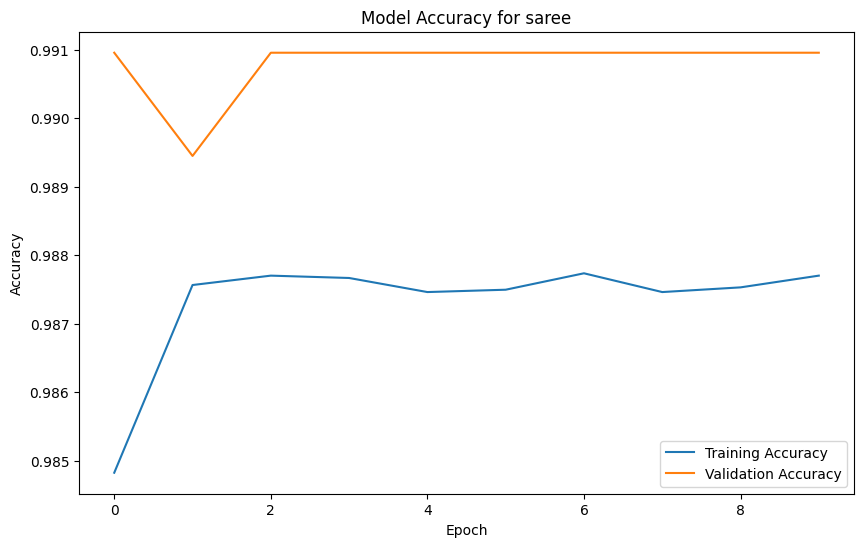

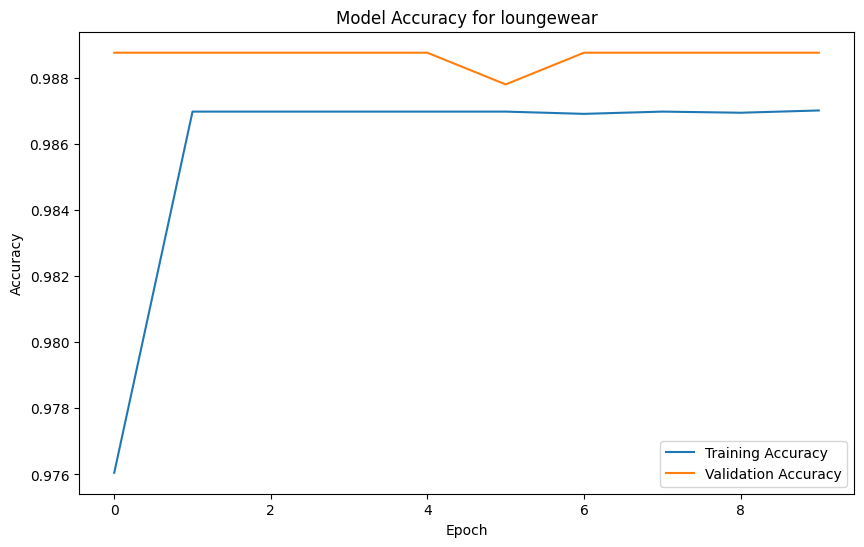

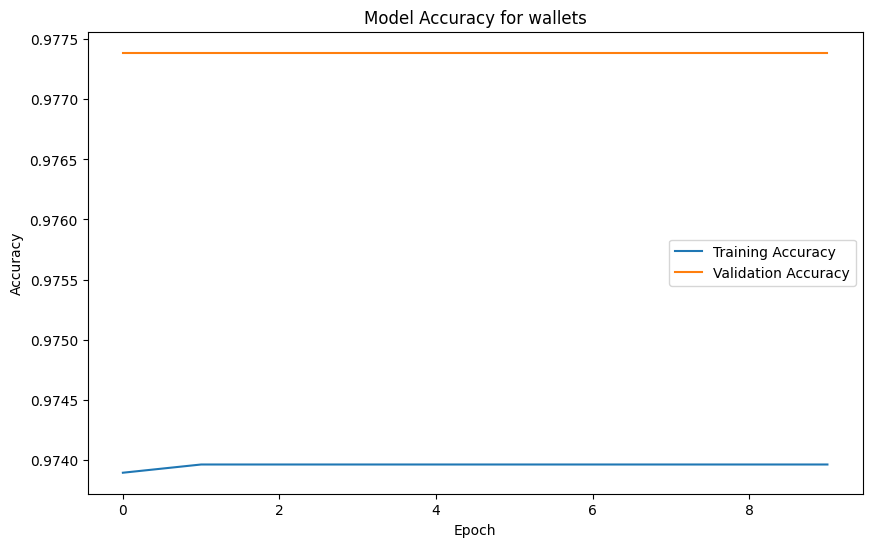

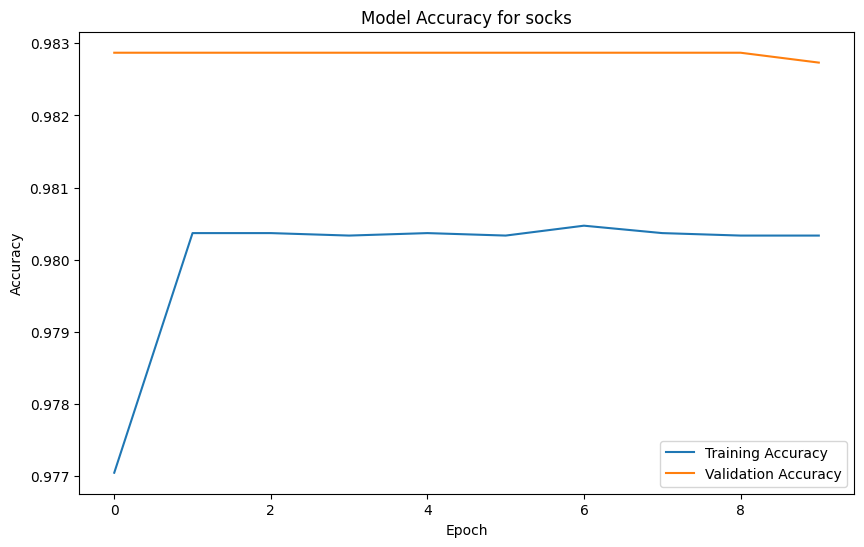

In [ ]:
import matplotlib.pyplot as plt

# Access the history object from your model's training process
history = model.history.history

# Plot the training and validation accuracy for each output
for output_name in model.output_names:
  plt.figure(figsize=(10, 6))
  # Changed the key format to match the expected format in history
  plt.plot(history[output_name + '_accuracy'], label='Training Accuracy')
  plt.plot(history['val_' + output_name + '_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy for ' + output_name)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# def recommend_complementary_items(model, data, product_id, label_encoder_gender, label_encoder_color, label_encoder_usage, scaler):
#     """
#     Recommends complementary items based on a given product ID.

#     Args:
#         model: The trained ANN model.
#         data: The DataFrame containing product information.
#         product_id: The ID of the product for which recommendations are needed.
#         label_encoder_gender: The LabelEncoder used for 'gender'.
#         label_encoder_color: The LabelEncoder used for 'baseColour'.
#         label_encoder_usage: The LabelEncoder used for 'usage'.
#         scaler: The scaler used for 'Price (USD)'.

#     Returns:
#         A list of recommended complementary item IDs.
#     """
#     try:
#         product_data = data[data['id'] == product_id].iloc[0]

#         # Extract relevant features from the product data
#         gender = product_data['gender']
#         baseColour = product_data['baseColour']
#         usage = product_data['usage']
#         price = product_data['Price (USD)']

#         # Encode the input features
#         gender_encoded = label_encoder_gender.transform([gender])[0]
#         baseColour_encoded = label_encoder_color.transform([baseColour])[0]
#         usage_encoded = label_encoder_usage.transform([usage])[0]
#         price_scaled = scaler.transform([[price]])[0, 0]

#         # Predict using the model
#         predictions = model.predict([
#             np.array([gender_encoded]),
#             np.array([baseColour_encoded]),
#             np.array([usage_encoded]),
#             np.array([price_scaled])
#         ])

#         # Define the subcategories to match the model's output layers
#         subcategories = ['Shoes', 'Bags', 'Watches', 'Flip Flops', 'Jewellery', 'Topwear',
#                          'Eyewear', 'Belts', 'Saree', 'Loungewear and Nightwear', 'Wallets', 'Socks']

#         # Get the index of the highest probability (excluding the product's own category)
#         product_category_index = subcategories.index(product_data['subCategory'])

#         # Get indices of top recommendations (excluding product's category)
#         top_indices = np.argsort(predictions[0][0])[-2:]  # Get indices of top 2 probabilities

#         # Filter out product's category from top recommendations
#         top_indices = [i for i in top_indices if i != product_category_index]


#         # Get recommended subcategories
#         recommended_subcategories = [subcategories[i] for i in top_indices]

#         # Find complementary items in the dataset
#         complementary_items = data[
#             (data['gender'] == gender) &
#             (data['baseColour'] == baseColour) &
#             (data['usage'] == usage) &
#             (data['masterCategory'].isin(recommended_subcategories))
#         ]['id'].tolist()

#         print(f"Complementary items for product ID {product_id}:")
#         for item_id in complementary_items:
#             print(item_id)

#     except IndexError:
#         print(f"Product with ID {product_id} not found in the dataset.")


# # Example usage:
# product_id_to_recommend = 8282  # Replace with an actual product ID
# recommend_complementary_items(model, data, product_id_to_recommend, label_encoder_gender, label_encoder_color, label_encoder_usage, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Complementary items for product ID 8282:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
